# Correlation / Least Squares Regression
*+ Non-linear regression, Regularization*

<hr>

**Mathematical definition of correlation**<br>
> Correlation measures the linear association between two variables

$Corr(X, Y) = \frac{Cov(X, Y)}{S_x \cdot S_y}$ <br>
where $S_x, S_y$ is the unbiased estimator of the standard deviation of X and Y, i.e. estimated with [Bessel's Correction](https://en.wikipedia.org/wiki/Bessel%27s_correction):
$S_x = \frac{1}{N-1} \sum (X_i - \bar{X}$)

```python
# Use ddof = 1, for an unbiased estimator
S_x = np.std(X, ddof = 1)
```
<hr>

**How does it relate to regression?**<br>

For a given $Y = B_1X + B_0$, <br>

$B_1 = Corr(X,Y) \cdot \frac{S_y}{S_x} = \frac{Cov(X, Y)}{S_x^2}$<br>
$E[B_0] = E[Y] - B_1E[X]$

<hr>

**Non-linear regression**<br>
Given a non-linear relationship between two variables, use a transformation such that the transformed variables, $X', Y'$ forms a linear relationship $Y' = k X' + \omega$

One possible transformation is the `Natural log on both sides`

Tips:
- Strong correlation observed between two variables needs to be checked with residual diagnostics (QQ plot, KS-test, etc)
- If residuals are non-Gaussian, possible non-linear transformation: consider applying natural log transformation to variables and response
- Transform the variables back into $X, Y$ and establish the non-linear relationship

Suppose, $\ln Y = k \ln X + \ln \omega$<br>
then, $Y = e^{k \ln x + \ln \omega}$<br>
finally, $Y = x^k \cdot \omega$

Consider trying out `scipy.optimize.curve_fit` to fit a non-linear relationship to determine the coefficients

<hr>

**Multivariate Regression**<br>
_Using Ordinary Least Squares (OLS)_

Suppose a multivariate model, $Y = X \beta$, then, least-squares:<br>

$\displaystyle\arg \min_{\substack{\beta}} \lVert Y - X \beta\rVert ^2$

To solve for $\beta$, set $X\beta - Y = 0$<br>

$X\beta = Y$<br>
$X^T X \beta = X^T Y$

If $X^T X$ is invertible<sup>1</sup>, then $(X^T X)^{-1} X^T X \beta = (X^T X)^{-1} X^T Y$

$\therefore \beta = (X^T X)^{-1} X^T Y$, which is a linear transformation of Y to $\beta$


<sup>1</sup> This is why $X$ has to be non-singular, i.e. an invertible matrix that has full rank (independent variables)

<hr>

**Variable Selection, by Regularization**<br>
_by L1, L2 norm_

When there are a large number of dimensions (D >> N), add a regularization term in the loss function to control for the number of dimensions used in the model.

*L2*:<br>
Penalizes large coefficients and results in a model where all coefficients are kept small and prevents overfitting

Minimize $\sum_{i=1}^{N} (y_i - \hat{y}) + \lambda \lVert B_j \rVert^2$

*L1 (LASSO: least absolute shrinkage and selection operator)*:<br>
Helps to select variables as it shrinks coefficients on variables with little predictive value to zero and therefore effectively removes them from the model

Minimize $\sum_{i=1}^{N} (y_i - \hat{y}) + \lambda \lVert B_j \rVert_1$

where $\lVert B_j \rVert_1 = \sum_{j=1}^{D} \lvert B_j \rvert$ 

**Variable Selection, by Significance**<br>
Run a t-test on all variables with a null hypothesis that $B_j = 0$

Test-statistic, $T = \frac{\hat{B_j} - B_j}{\hat{\sigma} \Sigma_j}$

where $\hat{\sigma}^2 = \frac{\lVert Y - \hat{y} \rVert^2}{N-d}$ and $\Sigma_j^2$ is the jth-diagonal element of $(X^T X)^{-1}$

<hr>

# Basic code
A `minimal, reproducible example`

## Compute covariance/correlation

In [1]:
# Raw data

import numpy as np

Xs = np.array([0.0339, 0.0423, 0.213, 0.257, 0.273, 0.273, 0.450, 0.503, 0.503, \
0.637, 0.805, 0.904, 0.904, 0.910, 0.910, 1.02, 1.11, 1.11, 1.41, \
1.72, 2.03, 2.02, 2.02, 2.02])

Ys = np.array([-19.3, 30.4, 38.7, 5.52, -33.1, -77.3, 398.0, 406.0, 436.0, 320.0, 373.0, \
93.9, 210.0, 423.0, 594.0, 829.0, 718.0, 561.0, 608.0, 1.04E3, 1.10E3, \
840.0, 801.0, 519.0])

N = 24

In [2]:
# Compute covariance by hand

x_bar = np.mean(Xs)
y_bar = np.mean(Ys)
cov = 1/(N-1) * np.sum((Xs - x_bar) * (Ys - y_bar))

print('Sample Mean, X: ', np.around(x_bar, 3)) 
print('Sample Mean, Y: ', np.around(y_bar, 3))
print('Cov(X, Y):\t', np.around(cov, 3))

Sample Mean, X:  0.92
Sample Mean, Y:  425.618
Cov(X, Y):	 191.207


In [3]:
# Compute correlation by hand, use ddof = 1 for unbiased estimator of SD

corr = cov / (np.std(Xs, ddof = 1) * np.std(Ys, ddof = 1))
print('Corr(X, Y):\t', np.around(corr, 4))

Corr(X, Y):	 0.8391


In [4]:
# Compute Y = B0 + B1*X

# For every change of 1 unit in X, what is the expected change of units in Y?
b1 = corr * np.std(Ys, ddof = 1) / np.std(Xs, ddof = 1)

# What is the expected residuals not predicted by X?
b0 = np.mean(Ys) - b1*np.mean(Xs)

print(f'Y = {b0:.3f} + {b1:.3f}*X')

Y = 13.610 + 447.871*X


## Non-linear regression

In [5]:
# Raw data

import numpy as np

Xs = np.array([ 0.387, 0.723, 1.00, 1.52, 5.20, 9.54, 19.2, 30.1, 39.5 ]) # Astronomical units, mean distance from planet to sun
Ys = np.array([ 0.241, 0.615, 1.00, 1.88, 11.9, 29.5, 84.0, 165.0, 248 ]) # Earth years
N  = 9                                                                    # Planets

In [6]:
# Basic plot

import matplotlib.pyplot as plt

plt.plot(Xs, Ys)
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
# Calculate correlation

x_bar, y_bar = np.mean(Xs), np.mean(Ys)
S_x, S_y = np.std(Xs, ddof = 1), np.std(Ys, ddof = 1)

cov  = 1/(N-1) * np.sum((Xs - x_bar) * (Ys - y_bar))
corr = cov/(S_x*S_y)

print(f'Correlation, Distance to Sun (X) vs Earth Years (Y): {corr:.3f}')

Correlation, Distance to Sun (X) vs Earth Years (Y): 0.989


In [8]:
# Form linear equation

b1 = corr * S_y / S_x
b0 = y_bar - b1*x_bar

print(f'Y = {b1:.3f}X + ({b0:.3f})')

Y = 6.109X + (-12.504)


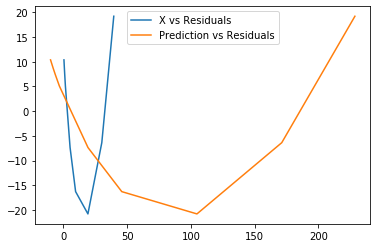

In [9]:
# Plot residuals against X, predicted Y

pred_y = b1*Xs + b0
resids = Ys - pred_y

plt.plot(Xs, resids)
plt.plot(pred_y, resids)
plt.legend(['X vs Residuals', 'Prediction vs Residuals'])
plt.show()

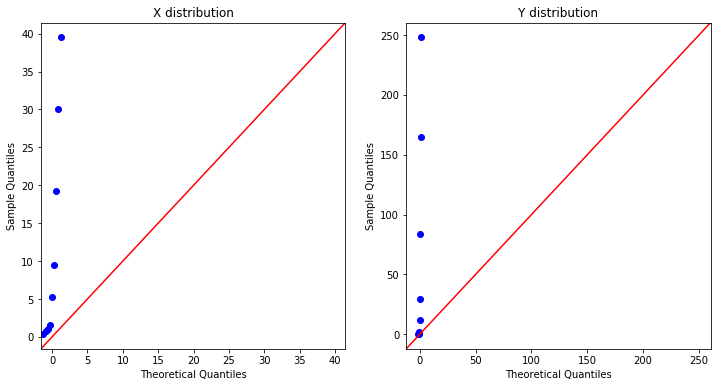

In [10]:
# QQ-plot to check if the marginal distributions of X and Y are normally distributed

import statsmodels.api as sm

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sm.qqplot(Xs, line='45', ax = ax1)
ax1.set_title("X distribution")

sm.qqplot(Ys, line='45', ax = ax2)
ax2.set_title("Y distribution")
plt.show()

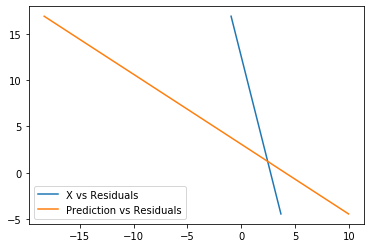

In [11]:
# Use a non-linear transformation to improve the fit

pred_y = b1*np.log(Xs) + b0
resids = np.log(Ys) - pred_y

plt.plot(np.log(Xs), resids)
plt.plot(pred_y, resids)
plt.legend(['X vs Residuals', 'Prediction vs Residuals'])
plt.show()

In [12]:
# Find the coefficients given transformed variables

x_bar, y_bar = np.mean(np.log(Xs)), np.mean(np.log(Ys))
S_x, S_y = np.std(np.log(Xs), ddof = 1), np.std(np.log(Ys), ddof = 1)

cov  = 1/(N-1) * np.sum((np.log(Xs) - x_bar) * (np.log(Ys) - y_bar))
corr = cov/(S_x*S_y)

print(f'Correlation, natural log of Distance to Sun (X) vs natural log of Earth Years (Y): {corr:.3f}')

b1 = corr * S_y / S_x
b0 = y_bar - b1*x_bar

print('-'*100)
print('Regression function, post-transformation:', '\n')
print(f"Y' = {b1:.3f}X' + ({b0:.3f})")
print("where Y', X' = np.log(Y), np.log(X)")

Correlation, natural log of Distance to Sun (X) vs natural log of Earth Years (Y): 1.000
----------------------------------------------------------------------------------------------------
Regression function, post-transformation: 

Y' = 1.500X' + (0.001)
where Y', X' = np.log(Y), np.log(X)


## Multivariate Regression

In [13]:
# Raw Data

import numpy as np

LogPlanetMass = np.array([-0.31471074,  1.01160091,  0.58778666,  0.46373402, -0.01005034,
         0.66577598, -1.30933332, -0.37106368, -0.40047757, -0.27443685,
         1.30833282, -0.46840491, -1.91054301,  0.16551444,  0.78845736,
        -2.43041846,  0.21511138,  2.29253476, -2.05330607, -0.43078292,
        -4.98204784, -0.48776035, -1.69298258, -0.08664781, -2.28278247,
         3.30431931, -3.27016912,  1.14644962, -3.10109279, -0.61248928])

LogPlanetRadius = np.array([ 0.32497786,  0.34712953,  0.14842001,  0.45742485,  0.1889661 ,
         0.06952606,  0.07696104,  0.3220835 ,  0.42918163, -0.05762911,
         0.40546511,  0.19227189, -0.16251893,  0.45107562,  0.3825376 ,
        -0.82098055,  0.10436002,  0.0295588 , -1.17921515,  0.55961579,
        -2.49253568,  0.11243543, -0.72037861,  0.36464311, -0.46203546,
         0.13976194, -2.70306266,  0.12221763, -2.41374014,  0.35627486])

LogPlanetOrbit = np.array([-2.63108916, -3.89026151, -3.13752628, -2.99633245, -3.12356565,
        -2.33924908, -2.8507665 , -3.04765735, -2.84043939, -3.19004544,
        -3.14655516, -3.13729584, -3.09887303, -3.09004295, -3.16296819,
        -2.3227878 , -3.77661837, -2.52572864, -4.13641734, -3.05018846,
        -2.40141145, -3.14795149, -0.40361682, -3.2148838 , -2.74575207,
        -3.70014265, -1.98923527, -3.35440922, -1.96897409, -2.99773428])

StarMetallicity = np.array([ 0.11 , -0.002, -0.4  ,  0.01 ,  0.15 ,  0.22 , -0.01 ,  0.02 ,
        -0.06 , -0.127,  0.   ,  0.12 ,  0.27 ,  0.09 , -0.077,  0.3  ,
         0.14 , -0.07 ,  0.19 , -0.02 ,  0.12 ,  0.251,  0.07 ,  0.16 ,
         0.19 ,  0.052, -0.32 ,  0.258,  0.02 , -0.17 ])

LogStarMass = np.array([ 0.27002714,  0.19144646, -0.16369609,  0.44468582,  0.19227189,
         0.01291623,  0.0861777 ,  0.1380213 ,  0.49469624, -0.43850496,
         0.54232429,  0.02469261,  0.07325046,  0.42133846,  0.2592826 ,
        -0.09431068, -0.24846136, -0.12783337, -0.07364654,  0.26159474,
         0.07603469, -0.07796154,  0.09440068,  0.07510747,  0.17395331,
         0.28893129, -0.21940057,  0.02566775, -0.09211529,  0.16551444])

LogStarAge = np.array([ 1.58103844,  1.06471074,  2.39789527,  0.72754861,  0.55675456,
         1.91692261,  1.64865863,  1.38629436,  0.77472717,  1.36097655,
         0.        ,  1.80828877,  1.7837273 ,  0.64185389,  0.69813472,
         2.39789527, -0.35667494,  1.79175947,  1.90210753,  1.39624469,
         1.84054963,  2.19722458,  1.89761986,  1.84054963,  0.74193734,
         0.55961579,  1.79175947,  0.91629073,  2.17475172,  1.36097655])

N = 30

In [14]:
# Solve for Beta
y    = np.copy(LogPlanetMass)
X    = np.array([np.zeros(len(y))+1, LogPlanetRadius, LogPlanetOrbit, StarMetallicity, LogStarMass, LogStarAge]).T
Beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(Beta)

[ 0.15379303  1.40214538 -0.14099818 -1.59951364 -0.95610919 -0.46176234]


In [15]:
# Compute the test statistic for all Betas

import numpy as np
np.set_printoptions(precision=6, suppress = True)

from scipy.stats import t

d         = len(Beta)
dof       = N - d
diagonal  = np.diag(np.linalg.inv(X.T.dot(X)))
sigma_hat = np.sqrt((y - X.dot(Beta)).T.dot((y - X.dot(Beta))) / dof)
T         = np.array([(Beta[j] - 0) / (sigma_hat * np.sqrt(diagonal[j])) for j in range(d)])
P         = np.array([1 - p if p >= 0.5 else p for p in t.cdf(T, df = dof)])*2
P_alt     = t.sf(np.abs(T), df = dof)*2

print(P)
print(P_alt)

[0.912757 0.000054 0.698599 0.21311  0.400457 0.225953]
[0.912757 0.000054 0.698599 0.21311  0.400457 0.225953]
